<a href="https://colab.research.google.com/github/hopeyen/allocation_solvers/blob/main/allocation_solver_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and client

In [ ]:
# Installation 
!pip install gql
!pip install gurobipy
!pip install web3
!pip install messari
!pip install python-dotenv


## If jsonschema version conflict
!pip install --force-reinstall jsonschema==3.2.0

     |████████████████████████████████| 252 kB 17.5 MB/s 
     |████████████████████████████████| 179 kB 45.4 MB/s 
     |████████████████████████████████| 11.5 MB 21.0 MB/s 
     |████████████████████████████████| 485 kB 28.7 MB/s 
     |████████████████████████████████| 103 kB 54.6 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 32.0 MB/s 
     |████████████████████████████████| 82 kB 910 kB/s 
     |████████████████████████████████| 160 kB 61.7 MB/s 
     |████████████████████████████████| 192 kB 62.9 MB/s 
     |████████████████████████████████| 271 kB 76.2 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 1.9 MB 49.0 MB/s 
     |████████████████████████████████| 481 kB 45.8 MB/s 
     |████████████████████████████████| 1.9 MB 41.2 MB/s 
  Created wheel for b

In [ ]:
# Import
from pprint import pprint
import copy
from getpass import getpass
from gql import Client, gql
from gql.transport.requests import RequestsHTTPTransport
from IPython.display import JSON, IFrame
import requests
import numpy as np
from web3 import Web3
from scipy.optimize import minimize

import pandas as pd

import gurobipy as gp
from gurobipy import GRB

from messari import Messari

import matplotlib.pyplot as plt


## Setup client


In [ ]:
# Set up client
api_url = 'https://gateway.thegraph.com/network'

token = getpass()

client = Client(
    transport=RequestsHTTPTransport(api_url, use_json=True, headers=dict(Authorization=f"token {token}")),
    fetch_schema_from_transport=True,
)

··········


# Allocations solver functions 

Let's make allocations an assignment problem and find the optimization for individual indexers

## Steps

1. Query info
  
  1.1 subgraph (signal and allocation)

  1.2 indexer (token capacity, amount allocated on each subgraph)

  1.3 network (total signal, total indexing rewards)

  1.4 prices (Ethereum gas price converted to GRT)

2. Calculate subgraph info if we unallocate

3. Create model variables

  3.1 allocation amount variable (independent)

  3.2 allocation free variable (since Gurobi goesn't allow variables in divisior)

  3.3 allocation boolean (for calculating costs)

4. Create Constraints

  4.1 Allocation amount constrainted to capacity

  4.2 Free variable constraint 
  
  4.3 Set boolean 

5. Solve with different algorithms!


## Data processing

In [ ]:
indexers = {
    'lemnis': {
        'address': '0xc60d0c8c74b5d3a33ed51c007ebae682490de261'
        },
    'prime1': {
        'address': '0x6ac85b9d834b51b14a7b0ed849bb5199e04c05c5'
        },
    'prime2': {
        'address': '0x6125ea331851367716bee301ecde7f38a7e429e7'
        }
}

In [ ]:
def query(query_string, params = {}):
  query_gql = gql(query_string)
  result = client.execute(query_gql, variable_values=params)
  return result
  
subgraphs_query = """
  query getSubgraphs {
    subgraphs(
      first: 1000
      skip: 0
      orderBy: signalledTokens
      orderDirection: desc
    ) {
      id
      displayName
      owner {
        id
      }
      currentVersion {
        id
        createdAt
        subgraphDeployment {
          id
          ipfsHash
          signalledTokens
          stakedTokens
          indexingRewardAmount
          queryFeesAmount
          deniedAt
          versions(first: 1000) {
            id
            subgraph {
              id
              currentVersion {
                id
                subgraphDeployment {
                  id
                }
              }
            }
          }
        }
      }
    }
  }
"""

# ordered in Lemnis, Prime-1, Prime-2
indexers_query = """
query getIndexers {
  indexers(
    where: {
      id_in: [
        "0xc60d0c8c74b5d3a33ed51c007ebae682490de261", 
        "0x6ac85b9d834b51b14a7b0ed849bb5199e04c05c5",
        "0x6125ea331851367716bee301ecde7f38a7e429e7"
        ]
      }
    ){
    id
    indexingRewardCut
    indexingRewardEffectiveCut
    allocatedTokens
    availableStake
    tokenCapacity
    stakedTokens
    delegatedTokens
    allocations{
      allocatedTokens
      subgraphDeployment{
        ipfsHash
        signalledTokens
        stakedTokens
        indexingRewardAmount
      }
    }
  }
}
"""

network_query = """{
  graphNetwork(id: "1"){
    totalTokensSignalled
    totalTokensAllocated
    totalSupply
    epochLength
    networkGRTIssuance
  }
}
"""


In [ ]:
subgraphs_data = query(subgraphs_query)
indexers_data = query(indexers_query)
network_data = query(network_query)

Got the data! clean it up


Network

In [ ]:
totalTokensSignalled = float(network_data['graphNetwork']['totalTokensSignalled'])/1e18
totalTokensAllocated = float(network_data['graphNetwork']['totalTokensAllocated'])/1e18
totalSupply = float(network_data['graphNetwork']['totalSupply'])/1e18
numBlockInDay = float(network_data['graphNetwork']['epochLength'])
networkGRTIssuance = float(network_data['graphNetwork']['networkGRTIssuance'])/1e18

Y = 365
## apparently 6500 is more accurate than numBlockInDay param
# daily_rewards = (totalSupply * networkGRTIssuance - totalSupply) * numBlockInDay
daily_rewards = (totalSupply * networkGRTIssuance - totalSupply) * 6500

Indexers

In [ ]:
# indexers
for indexer in indexers_data['indexers']:
  for indexer_name, data in indexers.items():
    if indexer['id'] == data['address']: indexers_data[indexer_name] = indexer

del indexers_data['indexers']

# indexer allocations
for indexer_name, indexer in indexers_data.items():
  indexer['indexingRewardEffectiveCut'] = float(indexer['indexingRewardEffectiveCut'])
  indexer['indexingRewardCut'] = float(indexer['indexingRewardCut'])/1e6
  indexer['stakedTokens'] = float(indexer['stakedTokens'])/1e18
  indexer['delegatedTokens'] = float(indexer['delegatedTokens'])/1e18
  indexer['allocatedTokens'] = float(indexer['allocatedTokens'])/1e18
  indexer_allocations_temp = dict()
  for allocation in indexer['allocations']:
    allocation['ipfsHash'] = allocation['subgraphDeployment']['ipfsHash']
    allocation['allocatedTokens'] = float(allocation['allocatedTokens'])/1e18
    allocation['stakedTokens'] = float(allocation['subgraphDeployment']['stakedTokens'])/1e18
    allocation['signalledTokens'] = float(allocation['subgraphDeployment']['signalledTokens'])/1e18
    indexer_allocations_temp[allocation['ipfsHash']] = allocation
  indexer['allocations'] = indexer_allocations_temp


# { indexer_name : ( token Capacity, current unallocated ) }
# use sum of the two to pre-calculate
indexer_capacities = dict()
for indexer_name in indexers:
  indexer_capacities[indexer_name] = ((float(indexers_data[indexer_name]['tokenCapacity']))/1e18, (float(indexers_data[indexer_name]['availableStake']))/1e18)


In [ ]:
# example
# indexers_data['lemnis']['allocations']['QmbL5761GrNnT8X3Emeny6NbXQxDwXxdpiER2boASKBhFW']

Subgraphs

In [ ]:
# flatten name
for subgraph in subgraphs_data['subgraphs']:
  subgraph['currentVersion']['subgraphDeployment']['displayName'] = subgraph['displayName']

# format into a dictionary with token factor         
subgraphs = {subg['currentVersion']['subgraphDeployment']['ipfsHash'] : 
              {'id': subg['currentVersion']['subgraphDeployment']['id'], 
               'ipfsHash': subg['currentVersion']['subgraphDeployment']['ipfsHash'], 
               'displayName': subg['currentVersion']['subgraphDeployment']['displayName'], 
               'signalledTokens': (float(subg['currentVersion']['subgraphDeployment']['signalledTokens'])/1e18), 
               'stakedTokens': (float(subg['currentVersion']['subgraphDeployment']['stakedTokens'])/1e18)} for subg in subgraphs_data['subgraphs']}

# for easy access later
subgraph_ipfs_hashes = list(set([subg['ipfsHash'] for id, subg in subgraphs.items()]))
current_allocations = {subg['ipfsHash']: (subg['stakedTokens']) for id, subg in subgraphs.items()}
current_signals = {subg['ipfsHash']: (subg['signalledTokens']) for id, subg in subgraphs.items()}

In [ ]:
# subgraph daily rewards
subgraph_daily_rewards_dict = {}
for subgraph_hash, subgraph in subgraphs.items():
  subgraph_daily_rewards_dict[subgraph_hash] = daily_rewards * ( subgraph['signalledTokens'] / totalTokensSignalled )

In [ ]:
def remove_allocations(indexer_allocations, subgraphs_allocation):
  return {ipfs : subgraphs_allocation[ipfs] - indexer_allocations[ipfs]['allocatedTokens'] if ipfs in indexer_allocations else subgraphs_allocation[ipfs]
          for ipfs in subgraphs_allocation}

stripped_allocations = dict()
for indexer_name in indexers:
  stripped_allocations[indexer_name] = remove_allocations(indexers_data[indexer_name]['allocations'], current_allocations)
stripped_all = remove_allocations(indexers_data['lemnis']['allocations'], remove_allocations(indexers_data['prime2']['allocations'], stripped_allocations['prime1']))


In [ ]:
indexer_daily_rewards_dict = { 'prime1': {}, 'prime2': {}, 'lemnis': {} }
for indexer_name, indexer in indexers_data.items():
  for hash, subg in indexer['allocations'].items():
    subg['allocation_daily_rewards'] = subg['allocatedTokens'] * (subgraph_daily_rewards_dict[hash] / subg['stakedTokens']) if hash in subgraph_daily_rewards_dict else 0
  total_daily_rewards = sum([subg['allocation_daily_rewards'] for subg in list(indexer['allocations'].values())])
  indexer_daily_rewards_dict[indexer_name] = (total_daily_rewards, total_daily_rewards / (indexer['stakedTokens']+indexer['delegatedTokens']) * Y * (1 - indexer['indexingRewardEffectiveCut']))


def calculate_rewards(indexer_name, allocation_amounts, stripped_allocations):
  indexer = indexers_data[indexer_name]
  total_daily_rewards = 0
  for ipfs in allocation_amounts:
    try:
      total_daily_rewards += allocation_amounts[ipfs] * subgraph_daily_rewards_dict[ipfs] / (allocation_amounts[ipfs] + stripped_allocations[ipfs])
    except ZeroDivisionError:
      continue
  return (total_daily_rewards, total_daily_rewards / (indexer['stakedTokens']+indexer['delegatedTokens']) * Y * (1 - indexer['indexingRewardEffectiveCut']))


# # current daily rewards and estimated APR - use this to check calculation precision with Ryabina.io
print('current estimated daily rewards and estimated APR')
current_allocation_by_indexer = dict()
for indexer_name in indexers:
  current_allocation_by_indexer[indexer_name] = dict()
  for subg_ipfs in subgraphs:
    current_allocation_by_indexer[indexer_name][subg_ipfs] = indexers_data[indexer_name]['allocations'][subg_ipfs]['allocatedTokens'] if subg_ipfs in indexers_data[indexer_name]['allocations'] else 0
  print(f'{indexer_name}: {calculate_rewards(indexer_name, current_allocation_by_indexer[indexer_name], stripped_allocations[indexer_name])}')


current estimated daily rewards and estimated APR
lemnis: (49698.38157326061, 0.08456483351425986)
prime1: (656.424352933117, 0.7150225422246148)
prime2: (38660.31227245611, 0.10358083908064783)


Remove our current allocation to calculate the network when we all unstake

# Allocation model main parameters

In [ ]:
blacklist_subgraphs = [
                      # #  # subgraph have issues
                      #  'QmNRkaVUwUQAwPwWgdQHYvw53A5gh3CP3giWnWQZdA2BTE', # Opyn
                       'QmaaDA7XVVktfxCLMgfwG1z3KM8DSMoLkbemkTt9mQT8Qf', # eip721
                      #  'QmZdsSbRwVD7VVVm5WGxZZC6HYvbjnFb4hcwvQ4fTs5bxA', # mStable - not fixed yet

                      #  # large subgraph, need off-chain sync
                      #  'QmZLFFChgZu6j4q8twaJn8xF74WgGgZ1WKEG6Cigesr49R', # Synthetix - Mainnet Mega
                      #  'QmVf6LXmnRGexmsA6BqiVdwtL22fDVN289pLU8qEhr5GqC', # 0x-exchange-proxy
                       'QmQj3DDJzo9mS9m7bHriw8XdnU3od65HSThebeeDBQiujP', # Wrapped ETH
                      #  'QmSqNTuVwKTYLXdBVULroCKh3pUNNBVUmcu8tXJAXXdeUr',  # USDC Protocol
                      
                      # #  # others
                       'QmYEq9PxgUEstxqE853qLMJ9MbowNrVVMGifFc8mUaHhhT', # Eth user lp tx, trouble syncing 
                       'QmWKj2tbgJKFgK1qw6oYFxW39AcxYvXpMcR9Kdtwi5yh56' # Cream iron bank
]

In [ ]:
lowerbound = 10000
upperbound = 50000

filtered_subgraph_ipfs_hashes = list(
    filter(
        lambda hash:
        (subgraphs[hash]['signalledTokens'] >=  lowerbound)
         & (subgraphs[hash]['stakedTokens'] >=  lowerbound)
        #  & (subgraphs[hash]['signalledTokens'] <=  upperbound)
         & (hash not in blacklist_subgraphs)
        #  & (hash not in indexers_data[indexer]['allocations'])
         , 
    subgraph_ipfs_hashes))

print(f'picking {len(filtered_subgraph_ipfs_hashes)} subgraphs out of {len(subgraph_ipfs_hashes)}')


picking 31 subgraphs out of 235


## Cost data

Eth gas price (transaction size seems to be a constant of 0.000283), and convert gas fee to GRT

In [ ]:
# grt per transaction, with default transaction size = 0.000283
# tx fee = tx size * gas fee (in eth)
TX_SIZE = 0.000283 

# initialize api client
messari = Messari()
w3 = Web3(Web3.HTTPProvider("https://erigon-mainnet--rpc.datahub.figment.io/apikey/0db3916394d1bd6202bc4d582415411d"))
  

# cost per transaction (estimate)
def gas_fee():
  return float(w3.eth.get_block('latest')['baseFeePerGas'])/1e9

# convert 1 eth to grt
def eth_to_grt():
  eth_resp = messari.get_asset_market_data(asset_key='eth', fields='market_data/price_usd')
  grt_resp = messari.get_asset_market_data(asset_key='grt', fields='market_data/price_usd')
  eth_in_usd = eth_resp['data']['market_data']['price_usd']
  grt_in_usd = grt_resp['data']['market_data']['price_usd']

  return eth_in_usd / grt_in_usd

# currently not used
def median_gas_fee():
  eth_asset_resp = messari.get_asset_metrics(asset_key='eth', fields='slug,on_chain_data/median_fee_native_units')

  return (eth_asset_resp['data']['on_chain_data']['median_fee_native_units'])

def tx_fee_in_eth():
  return TX_SIZE * gas_fee()

def tx_fee_in_grt():
  return eth_to_grt() * tx_fee_in_eth()

# estimate gas fee
print('gas fee: ', gas_fee())
print('tx fee in eth: ', TX_SIZE * gas_fee())
print('tx fee in grt: ', tx_fee_in_grt())

gas fee:  100.593164499
tx fee in eth:  0.028467865553217
tx fee in grt:  136.04541973308983


# Just One (clean and should work)

In [ ]:
print(len(filtered_subgraph_ipfs_hashes))
print(indexer_capacities)
print(indexer_daily_rewards_dict)
print(tx_fee_in_grt()/eth_to_grt())

31
{'lemnis': (188039948.02407995, 12498306.024079971), 'prime1': (1490028.8200429277, 0.8200429276810135), 'prime2': (132122412.96887879, 181323.96887878006)}
{'prime1': (656.4244031135031, 0.7150225968845418), 'prime2': (38660.284547144416, 0.10358286971662485), 'lemnis': (49698.38537245539, 0.08456483997882197)}
0.05584519749773014


In [ ]:
indexer = 'lemnis'
# allocation_capacity = sum(indexer_capacities[indexer])
# allocation_capacity = indexer_capacities[indexer][0]
allocation_capacity = 175000000

print(allocation_capacity) 

175000000


In [53]:
factory = gp.Model('Allocation calculator')


subgraph_allocations = stripped_allocations[indexer]
hashes = filtered_subgraph_ipfs_hashes

# Variable declaration 
x_allocate = factory.addVars(hashes, name="SubgraphAllocation")
y_allocate = factory.addVars(hashes, name="SubgraphAllocationFree")

# Allocation Capacity constraint
AllocationCap = factory.addConstr((gp.quicksum(x_allocate) == allocation_capacity),
                   name = "Capacity")

# Free variable constraint
FreeVarEquates = factory.addConstrs((y_allocate[i] * (subgraph_allocations[i] + x_allocate[i]) == x_allocate[i] for i in hashes),
                   name = "Free")

#0. Objective Function
obj = gp.quicksum(( current_signals[i] * y_allocate[i] ) for i in hashes)

factory.setObjective(obj, GRB.MAXIMIZE)

factory.Params.NonConvex=2
factory.Params.TIME_LIMIT = 240

factory.optimize()


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 240
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 1 rows, 62 columns and 31 nonzeros
Model fingerprint: 0x120b0c7d
Model has 31 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 2e+08]
  Objective range  [1e+04, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+08, 2e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.00s
Presolved: 125 rows, 63 columns, 186 nonzeros
Presolved model has 31 bilinear constraint(s)
Variable types: 63 continuous, 0 integer (0 binary)

Root relaxation: objective 2.536306e+05, 58 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node

In [ ]:
# Print output
print('indexer: ' + indexer)
print('lowerbound: ' + str(lowerbound))
# print("currently allocated: " + str(sum(list(current_allocation_by_indexer[indexer].values()))))
print("allocation_capacity: " + str(allocation_capacity))
# cur_val = 0
# for i in current_allocation_by_indexer[indexer]:
#   if i in current_signals:
#     cur_val += current_signals[i] / current_allocations[i] * current_allocation_by_indexer[indexer][i]
# print("current value ", cur_val)
print("Objective value ", factory.ObjVal)

result_allocation_dictionary = {'lemnis':{}, 'prime1':{},'prime2':{}}
sum_allo = 0
num_tx = 0
for x in x_allocate.items():
  if (int(x[1].x) != 0): 
    sum_allo += int(x[1].x)
    num_tx += 1
  # else:
    # print (f'no {x[0]}')

  result_allocation_dictionary[indexer][x[0]] = int(x[1].x)

num_days = 14
cost = tx_fee_in_grt()
# # if we force cost to be 
# cost = 0.03 * eth_to_grt()

edr, apr = calculate_rewards(indexer, result_allocation_dictionary[indexer], stripped_allocations[indexer])
cedr, capr = calculate_rewards(indexer, current_allocation_by_indexer[indexer], stripped_allocations[indexer])

print("token_allocated: " + str(sum_allo))
print("extra tokens: " + str(allocation_capacity-sum_allo))
print(f'tx_fee * num_tx = {cost} * {num_tx} = {cost * num_tx} ; cost in eth per tx:  {tx_fee_in_eth()} ; eth needed to open: {cost * num_tx / eth_to_grt()}')
print(f'current daily reward, APR: {indexer_daily_rewards_dict[indexer]}')
print(f'estimated daily reward, APR: {edr, apr}')
print(f'Assume we need 2.3 tx for each allocation: open, close, claim. Assume we leave this for {num_days} days')
print(f'edr * num_days - 2.3 * cost * num_tx = {edr} * {num_days} - 2.3 * {cost} * {num_tx} = {edr * num_days - 2.3 * cost * num_tx}')
print(f'if cost == 150GRT then               = {edr} * {num_days} - 2.3 * {150} * {num_tx} = {edr * num_days - 2.3 * 150 * num_tx}')
print(f'compared to not touch this for {num_days} days: cedr * num_days  = {cedr} * {num_days} = {cedr * num_days}')


always_commands(x_allocate)




indexer: prime2
lowerbound: 20000
allocation_capacity: 132122412.96887879
Objective value  162028.69027015072
token_allocated: 132122402
extra tokens: 10.968878790736198
tx_fee * num_tx = 280.5401071839913 * 23 = 6452.422465231801 ; cost in eth per tx:  0.059116720512635 ; eth needed to open: 1.3596963801211457
current daily reward, APR: (38660.284547144416, 0.10358286971662485)
estimated daily reward, APR: (39493.5092765992, 0.1058153366942162)
Assume we need 2.3 tx for each allocation: open, close, claim. Assume we leave this for 14 days
edr * num_days - 2.3 * cost * num_tx = 39493.5092765992 * 14 - 2.3 * 280.5401071839913 * 23 = 538068.5582023556
if cost == 150GRT then               = 39493.5092765992 * 14 - 2.3 * 150 * 23 = 544974.1298723888
compared to not touch this for 14 days: cedr * num_days  = 38660.28454714442 * 14 = 541243.9836600219
----------------- always commands -----------------
graph indexer rules set QmNRkaVUwUQAwPwWgdQHYvw53A5gh3CP3giWnWQZdA2BTE decisionBasis alway

In [ ]:
factory.write("model.mps")
factory.computeIIS()
factory.write("model_IIS.ilp")


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0        75         -         0        74         -           0s
       38        38         -         0         0         -           0s

IIS computed: 38 constraints, 0 bounds
IIS runtime: 0.04 seconds


# Print indexer agent commands

In [ ]:
def always_commands(allocations):
  print('----------------- always commands -----------------')
  for x in allocations.items():
    if (int(x[1].x) != 0): 
      print (f'graph indexer rules set {x[0]} decisionBasis always parallelAllocations 1 allocationAmount {int(x[1].x)}')

def stop_commands(indexer_name):
  print('----------------- stop commands -----------------')
  for allocation in indexers_data[indexer_name]['allocations']:
    print(f'graph indexer rules stop {allocation}')

def print_subgs(subgraphs, signals, allocations):
  for subgraph_hash in subgraphs:
    print(subgraph_hash + ', ' + str(signals[subgraph_hash]) + ', ' + str(allocations[subgraph_hash]))


stop_commands(indexer)

----------------- stop commands -----------------
graph indexer rules stop QmNRkaVUwUQAwPwWgdQHYvw53A5gh3CP3giWnWQZdA2BTE
graph indexer rules stop QmVf6LXmnRGexmsA6BqiVdwtL22fDVN289pLU8qEhr5GqC
graph indexer rules stop QmcKFhdu1pM4ycFmqiYV6XJv3tC9UDmBRQyZ5FsAtgAQnX
graph indexer rules stop QmbL5761GrNnT8X3Emeny6NbXQxDwXxdpiER2boASKBhFW
graph indexer rules stop QmTiKBqwDjDtjAoCNgKLFjyg9UmwyFkVMFRVzBdnFmwYEi
graph indexer rules stop QmXtz8Zf837khnHFX1DbPY8cv97fSNd25T19Fjgv4yekGd
graph indexer rules stop QmWXF3jTLo6Wy9MxDZz6WKhET3GFcSFqn6vmrDDYPF7UHK
graph indexer rules stop QmTBxvMF6YnbT1eYeRx9XQpH4WvxTV53vdptCCZFiZSprg
graph indexer rules stop QmZdsSbRwVD7VVVm5WGxZZC6HYvbjnFb4hcwvQ4fTs5bxA
graph indexer rules stop QmTYMx6Ls53MfqAPYbPwMyt45KKzayznc2kxeDiwmgvtF9
graph indexer rules stop QmRLE9ueEaDvBD57qsgUBANmyXwd7f8cybj8oTcVWC4KGb
graph indexer rules stop QmWkVS3Uzr2WsTwvxtte2dpHbSYJSQ1bTQMVciKXCWx7TM
graph indexer rules stop QmZLFFChgZu6j4q8twaJn8xF74WgGgZ1WKEG6Cigesr49R
graph indexer 

# Scipy whyyy :((

  It won't run, maybe I should put everything in a matrix!

In [ ]:
# from scipy.optimize import show_options
# show_options(solver="minimize")
# show_options(solver="minimize", method="SLSQP")
import pandas as pd
import numpy as np
from scipy import optimize

min_allocations = 5
num_subgs = len(subgraph_ipfs_hashes)

signals = np.array([current_signals[hash] for hash in (subgraph_ipfs_hashes)])
allocations = np.array([stripped_allocations[indexer][hash] for hash in (subgraph_ipfs_hashes)])

def print_state(x):
  print('-----------------------')
  print('signals: ', str(signals))
  print('allocations: ', str(allocations))
  print('x: ', str(x))

def objective(x):
  obj_func = sum(
      - signals[i] / (allocations[i] + x[i]) * x[i] * rewards_factor(12) - gas_fee() if x[i] > 0
        else 0
      for i in range(num_subgs))
  return obj_func

def total_allocation_constraint(x):
  return indexer_capacities['lemnis'][0] - sum(x[i] for i in range(num_subgs))

# initial guesses
initial = np.array([indexer_capacities['lemnis'][0]/num_subgs for _ in range(num_subgs)])

allo_upper_bd = indexer_capacities['lemnis'][0] / min_allocations

# constraints
bnds = [(0.0, allo_upper_bd) for _ in range(num_subgs)]
con1 = {'type': 'eq', 'fun': total_allocation_constraint}

# show initial objective
print('Initial Objective: ' + str(objective(initial)))
print('capacities: ', str(indexer_capacities))
# optimize
res = optimize.minimize(objective, x0=initial, method = 'SLSQP', options={'maxiter':1000, 'disp': True},\
                    bounds=bnds,constraints=[con1])
res_df = pd.DataFrame({'min_val':res.x})
res.fun

x = res.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

# print solution
print('Solution')
for i in range(n):
  print(str(subgraph_ipfs_hashes[i]) + ":" + str(x[i]))

print_subgs(subgraphs, current_allocations)


# Monitoring

In [ ]:
def make_block_params(block_number):
 return {
      "block_num": block_number,
  }


subgraphs_query = """query getSubgraphs ($block_num:Int!) {
        subgraphs(
          first: 1000
          skip: 0
          orderBy: displayName
          orderDirection: asc
          block: { number: $block_num }
        ) {
          displayName
          currentVersion {
            subgraphDeployment {
              ipfsHash
              signalledTokens
            }
          }
        }
      }
"""


indexers_query = """query getIndexers ($block_num:Int!)  {
          lemnis: indexer(id: "0xc60d0c8c74b5d3a33ed51c007ebae682490de261"
                          block: { number: $block_num }){
            stakedTokens
            delegatedTokens
            indexingRewardEffectiveCut
            allocations{
              allocatedTokens
              subgraphDeployment{
                ipfsHash
                stakedTokens
              }
            }
          }
          
          prime1: indexer(id: "0x6ac85b9d834b51b14a7b0ed849bb5199e04c05c5"
                          block: { number: $block_num }){
            stakedTokens
            delegatedTokens
            indexingRewardEffectiveCut
            allocations{
              allocatedTokens
              subgraphDeployment{
                ipfsHash
                stakedTokens
              }
            }
          }
          
          prime2: indexer(id: "0x6125ea331851367716bee301ecde7f38a7e429e7"
                          block: { number: $block_num }){
            stakedTokens
            delegatedTokens
            indexingRewardEffectiveCut
            allocations{
              allocatedTokens
              subgraphDeployment{
                ipfsHash
                stakedTokens
              }
            }
          }
}
"""

network_query = """query getNetwork  ($block_num:Int!) {
  graphNetwork(id: "1"
              block: { number: $block_num }){
      totalTokensSignalled
      totalTokensAllocated
      totalSupply
      epochLength
      networkGRTIssuance
    }
}
"""
result_by_block = dict()
# 13584548
for block_number in range(12400000, 13584548, 1000):
  if block_number % 10000 == 0: print(block_number)
  params = make_block_params(block_number)
  subgraphs_data = query(subgraphs_query, params)
  indexers_data = query(indexers_query, params)
  network_data = query(network_query, params)

  # network
  totalTokensSignalled = float(network_data['graphNetwork']['totalTokensSignalled'])/1e18
  totalTokensAllocated = float(network_data['graphNetwork']['totalTokensAllocated'])/1e18
  totalSupply = float(network_data['graphNetwork']['totalSupply'])/1e18
  numBlockInDay = float(network_data['graphNetwork']['epochLength'])
  networkGRTIssuance = float(network_data['graphNetwork']['networkGRTIssuance'])/1e18

  # indexer allocations
  for indexer_name, indexer in indexers_data.items():
    indexer['indexingRewardEffectiveCut'] = float(indexer['indexingRewardEffectiveCut'])
    # indexer['indexingRewardCut'] = float(indexer['indexingRewardCut'])/1e6
    indexer['stakedTokens'] = float(indexer['stakedTokens'])/1e18
    indexer['delegatedTokens'] = float(indexer['delegatedTokens'])/1e18
    # indexer['allocatedTokens'] = float(indexer['allocatedTokens'])/1e18
    for allocation in indexer['allocations']:
      allocation['ipfsHash'] = allocation['subgraphDeployment']['ipfsHash']
      allocation['allocatedTokens'] = float(allocation['allocatedTokens'])/1e18
      allocation['stakedTokens'] = float(allocation['subgraphDeployment']['stakedTokens'])/1e18
      # allocation['signalledTokens'] = float(allocation['subgraphDeployment']['signalledTokens'])/1e18

  Y = 365
  # daily_rewards = (totalSupply * networkGRTIssuance - totalSupply) * numBlockInDay # apparently numBlockInDay is more accurate
  daily_rewards = (totalSupply * networkGRTIssuance - totalSupply) * 6500

  # subgraph daily rewards
  subgraph_daily_rewards_dict = {}
  for subgraph in subgraphs_data['subgraphs']:
    hash = subgraph['currentVersion']['subgraphDeployment']['ipfsHash'] 
    subgraph_daily_rewards_dict[hash] = daily_rewards * ( float(subgraph['currentVersion']['subgraphDeployment']['signalledTokens'])/1e18 / totalTokensSignalled )


  indexer_daily_rewards_dict = { 'prime1': {}, 'prime2': {}, 'lemnis': {} }
  for indexer_name, indexer in indexers_data.items():
    for subg in indexer['allocations']:
      subg['allocation_daily_rewards'] = subg['allocatedTokens'] * (subgraph_daily_rewards_dict[subg['ipfsHash']] / subg['stakedTokens']) if subg['ipfsHash'] in subgraph_daily_rewards_dict else 0

    total_daily_rewards = sum([subg['allocation_daily_rewards'] for subg in indexer['allocations']])
    indexer_daily_rewards_dict[indexer_name] = (total_daily_rewards, total_daily_rewards / (indexer['stakedTokens']+indexer['delegatedTokens']) * Y * (1 - indexer['indexingRewardEffectiveCut']))
  
  result_by_block[block_number] = indexer_daily_rewards_dict



13000000


In [ ]:
blocks = list(result_by_block.keys())

lemnis_edr = [data['lemnis'][0] for block_num, data in result_by_block.items()]
lemnis_apr = [data['lemnis'][1] for block_num, data in result_by_block.items()]
prime1_edr = [data['prime1'][0] for block_num, data in result_by_block.items()]
prime1_apr = [data['prime1'][1] for block_num, data in result_by_block.items()]
prime2_edr = [data['prime2'][0] for block_num, data in result_by_block.items()]
prime2_apr = [data['prime2'][1] for block_num, data in result_by_block.items()]


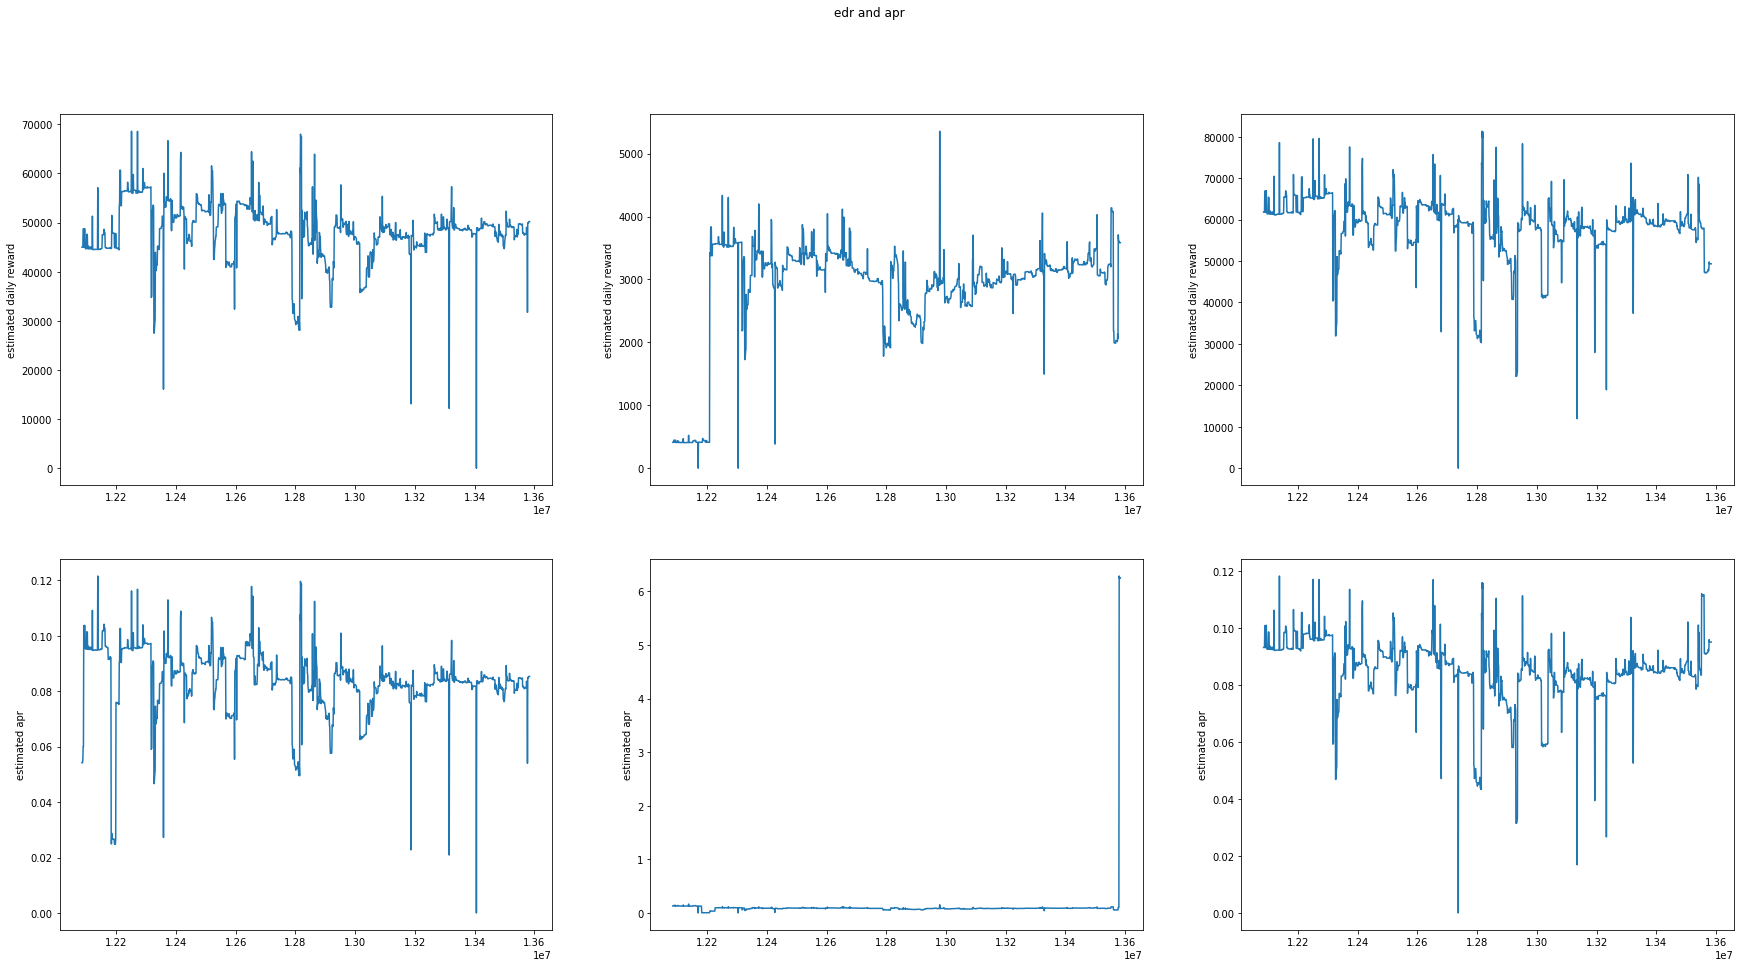

In [ ]:


fig, ((ax1_lemnis, ax1_prime1, ax1_prime2), (ax2_lemnis, ax2_prime1, ax2_prime2)) = plt.subplots(2, 3,figsize=(30,15))
fig.suptitle('edr and apr')

ax1_lemnis.plot(blocks, lemnis_edr, '-')
ax1_lemnis.set_ylabel('estimated daily reward')
ax2_lemnis.plot(blocks, lemnis_apr, '-')
ax2_lemnis.set_ylabel('estimated apr')

ax1_prime1.plot(blocks, prime1_edr, '-')
ax1_prime1.set_ylabel('estimated daily reward')
ax2_prime1.plot(blocks, prime1_apr, '-')
ax2_prime1.set_ylabel('estimated apr')

ax1_prime2.plot(blocks, prime2_edr, '-')
ax1_prime2.set_ylabel('estimated daily reward')
ax2_prime2.plot(blocks, prime2_apr, '-')
ax2_prime2.set_ylabel('estimated apr')

plt.show()

